# QF605 Part II

###### Prepared By:  

Dani Pangestu  
Gabriel Woon  
Gabriel Tan  
Kenneth Chong  
Peter Chettiar  
Yong Wen

In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import brentq, curve_fit, least_squares
from scipy.stats import norm
from scipy import interpolate

from math import log, exp, sqrt
import scipy.stats as ss

### Brief introduction

A swaption is an option to enter into an interest rate swap. The time distance between “today” and the option’s exercise date is called expiry, while the time distance between the exercise date and the swap’s maturity is called tenor.

### 1. Calibrate the displaced-diffusion model to the swaption market data

In [2]:
#Creating a dataframe for DD model

df_DD = pd.read_excel('IR Data.xlsx', 'Swaption', index_col=[0,1], skiprows=[0,1])
df_DD = df_DD.divide(100)
df_DD

-200bps  -150bps  -100bps   -50bps   -25bps     ATM  +25bps  \
Expiry Tenor                                                                
1Y     1Y     0.91570  0.62030  0.44130  0.31224  0.26182  0.2250  0.2096   
       2Y     0.83270  0.61240  0.46570  0.35807  0.31712  0.2872  0.2712   
       3Y     0.73920  0.56870  0.44770  0.35745  0.32317  0.2978  0.2829   
       5Y     0.55190  0.44640  0.36510  0.30242  0.27851  0.2607  0.2498   
       10Y    0.41180  0.35040  0.30207  0.26619  0.25351  0.2447  0.2398   
5Y     1Y     0.67800  0.49090  0.38400  0.31485  0.29060  0.2726  0.2604   
       2Y     0.57880  0.46410  0.39033  0.33653  0.31531  0.2983  0.2856   
       3Y     0.53430  0.44440  0.38180  0.33437  0.31536  0.2998  0.2876   
       5Y     0.41990  0.36524  0.32326  0.29005  0.27677  0.2660  0.2573   
       10Y    0.34417  0.30948  0.28148  0.25954  0.25136  0.2451  0.2399   
10Y    1Y     0.55160  0.44320  0.37368  0.32259  0.30210  0.2854  0.2731   
       2Y     0.51170  0.42900  0.37078  0.32622  0.30800  0.2928  0.2809   
       3Y     0.48220  0.41430  0.36400  0.32439  0.30796  0.2940  0.2827   
       5Y     0.40550  0.35891  0.32181  0.29144  0.27857  0.2674  0.2580   
       10Y    0.33601  0.30509  0.27978  0.25926  0.25086  0.2437  0.2376   

              +50bps  +100bps  +150bps  +200bps  
Expiry Tenor                                     
1Y     1Y     0.2140   0.2434  0.27488  0.30297  
       2Y     0.2684   0.2851  0.31025  0.33523  
       3Y     0.2780   0.2877  0.30725  0.32833  
       5Y     0.2456   0.2512  0.26536  0.28165  
       10Y    0.2382   0.2425  0.25204  0.26355  
5Y     1Y     0.2532   0.2494  0.25320  0.25980  
       2Y     0.2765   0.2671  0.26540  0.26760  
       3Y     0.2782   0.2667  0.26200  0.26150  
       5Y     0.2502   0.2406  0.23570  0.23400  
       10Y    0.2356   0.2291  0.22490  0.22250  
10Y    1Y     0.2645   0.2561  0.25520  0.25780  
       2Y     0.2720   0.2612  0.25720  0.25710  
       3Y     0.2738   0.2618  0.25580  0.25370  
       5Y     0.2502   0.2387  0.23170  0.22800  
       10Y    0.2324   0.2244  0.21900  0.21560

In [3]:
#Matrix form of our forward swap rates
FSwapRate = pd.read_excel('df_comb.xlsx', sheet_name='Fswap_rate',index_col=[0])
FSwapRate

,1Y,2Y,3Y,5Y,10Y
1Y,0.032007,0.033259,0.034011,0.035255,0.038428
5Y,0.039274,0.040075,0.040072,0.041093,0.043634
10Y,0.042190,0.043116,0.044097,0.046249,0.053458


In [4]:
#Just pulling out the OIS discount factors (expanded) from part 1

df_comb=pd.read_excel('df_comb.xlsx', index_col=[0])
OIS_all=df_comb.iloc[:,1]
OIS_all

1     0.998752
2     0.997009
3     0.995270
4     0.993531
5     0.991773
6     0.990015
7     0.988066
8     0.986117
9     0.984150
10    0.982184
11    0.979733
12    0.977283
13    0.974844
14    0.972406
15    0.969652
16    0.966898
17    0.964160
18    0.961422
19    0.958700
20    0.955977
21    0.953107
22    0.950236
23    0.947383
24    0.944529
25    0.941693
26    0.938857
27    0.936037
28    0.933218
29    0.930416
30    0.927614
31    0.924827
32    0.922040
33    0.919270
34    0.916500
35    0.913747
36    0.910994
37    0.908257
38    0.905520
39    0.902800
40    0.900080
41    0.897375
42    0.894670
43    0.891982
44    0.889293
45    0.886621
46    0.883949
47    0.881292
48    0.878636
49    0.875996
50    0.873355
51    0.870731
52    0.868106
53    0.865498
54    0.862889
55    0.860296
56    0.857703
57    0.855126
58    0.852548
59    0.849986
60    0.847424
Name: OIS_DF, dtype: float64

In [5]:
#Now to create a list of strikes and seperating them in terms of reciever and payer strikes

strikes=list(df_DD.columns)
strikes.remove('ATM')
allK=[int(i.strip('bps'))/10000 for i in strikes]
ReceiverK=np.array([i for i in allK if i<0])
PayerK=np.array([i for i in allK if i>0])

In [6]:
#Black 76 using PVBP (P) as discount factor
def Black76(F,K,P,sigma,T,Type):
    d1= (np.log(F/K)+(1/2)*sigma**2*T) / (sigma*np.sqrt(T))
    d2=d1 - sigma*np.sqrt(T)
    if Type=='Call': #payer
        return P*(F*norm.cdf(d1) - K*norm.cdf(d2))
    if Type=='Put': #reciever
        return P*(K*norm.cdf(-d2) - F*norm.cdf(-d1))
    else:
        raise Exception('payoffType not supported')

In [7]:
def impliedVolatility(F,K,P,price,T,Type):
    impliedVol = brentq(lambda x: price -Black76(F,K,P,x,T,Type), 1e-6, 1)
    return impliedVol

In [8]:
def Displaced_diffusion(F,K,P,sigma,T,beta,Type):
    Fd=F/beta
    sigmad=sigma*beta
    Kd=K+((1-beta)/beta)*F
    d1 = (np.log(Fd/Kd)+(sigmad**2/2)*T) / (sigmad*np.sqrt(T))
    d2 = d1 - sigmad*np.sqrt(T)
    if Type=='Call':
        return P*(Fd*norm.cdf(d1) - Kd*norm.cdf(d2))
    if Type=='Put':
        return P*(Kd*norm.cdf(-d2) - Fd*norm.cdf(-d1))
    else:
        raise Exception('payoffType not supported')

In [9]:
def DDcalibration(F,ATMK,ReceiverK,PayerK,vols,x,T,P):
    K_Receiver= ATMK+ReceiverK
    K_Receiver=list(K_Receiver)+[ATMK]
    implied_Receiver=[]
    for i in K_Receiver:
        DD_Receiver=Displaced_diffusion(F,i,P,x[0],T,x[1],'Put')
        implied_Rec=impliedVolatility(F,i,P,DD_Receiver,T,'Put')
        implied_Receiver.append(implied_Rec)

    K_Payer= ATMK+PayerK
    K_Payer=list(K_Payer)
    implied_Payer=[]
    for i in K_Payer:
        DD_Payer=Displaced_diffusion(F,i,P,x[0],T,x[1],'Call')
        implied_Pay=impliedVolatility(F, i,P,DD_Payer,T,'Call')
        implied_Payer.append(implied_Pay)

    impliedvol_DD=implied_Receiver+implied_Payer

    err=0.0
    for i, vol in enumerate(vols):
        if i==5:
            err += 10*(vol - impliedvol_DD[i])**2
        else:
            err += (vol - impliedvol_DD[i])**2
    return err,impliedvol_DD

In [10]:
#Initialising lists for calibration

Beta=[]
Vol=[]

initialGuess_dd=[0.3,0.6]

In [11]:
ExpTenor = ['1x1','1x2', '1x3','1x5','1x10',
            '5x1','5x2', '5x3','5x5','5x10',
            '10x1','10x2', '10x3','10x5','10x10']
T_2 = [[1,1],[1,2],[1,3],[1,5],[1,10],[5,1],[5,2],[5,3],[5,5],[5,10],[10,1],[10,2],[10,3],[10,5],[10,10]]

In [12]:
# Use Least Square to search for optimal Beta for different forward swap terms
# Calibrate DD model

for i in range(len(df_DD.index)):
    vols = df_DD.iloc[i,:].values
    F = FSwapRate.loc[df_DD.index[i][0],df_DD.index[i][1]]
    ATMK = F
    T = int(df_DD.index[i][0].strip('Y'))
    n = int(df_DD.index[i][0].strip('Y'))*2
    N = n+int(df_DD.index[i][1].strip('Y'))*2
    P = sum(OIS_all.iloc[n:N])/2
    
    
    w = least_squares(lambda x:DDcalibration(F,ATMK,ReceiverK,PayerK,vols,x,T,P)[0],
                      initialGuess_dd,
                      bounds=([0.01,0.01],[0.6,1]))  
    
    vol = w.x[0]
    beta = w.x[1]
    
    Vol.append(vol)
    Beta.append(beta)

In [13]:
#tabulate ATM vol for DD model
df_sigma = pd.DataFrame(data    = np.array(Vol).reshape(3,5),
                        index   = ['1y','5y','10y'], 
                        columns = ['1y','2y','3y','5y','10y'])
df_sigma

,1y,2y,3y,5y,10y
1y,0.307542,0.345404,0.341398,0.289518,0.259990
5y,0.302838,0.312472,0.308905,0.272008,0.247628
10y,0.296200,0.297524,0.294184,0.267308,0.243554


In [14]:
#tabulate optimal beta for DD model
df_beta  = pd.DataFrame(data    = np.array(Beta).reshape(3,5),
                        index   = ['1y','5y','10y'], 
                        columns = ['1y','2y','3y','5y','10y'])
df_beta

,1y,2y,3y,5y,10y
1y,0.012154,0.015845,0.031462,0.111442,0.295188
5y,0.052560,0.107758,0.144572,0.249040,0.367633
10y,0.121313,0.180841,0.146493,0.286947,0.386948


In [15]:
#Dataframe for DD IV
zipped_list = list(zip(Vol, Beta))
df_DDImpVol = pd.DataFrame()
for i in range(len(zipped_list)):
    df_DDImpVol[ExpTenor[i]+' DisDifImv'] = DDcalibration(F,ATMK,ReceiverK,PayerK,vols,zipped_list[i],T,P)[1]
df_DDImpVol

,1x1 DisDifImv,1x2 DisDifImv,1x3 DisDifImv,1x5 DisDifImv,1x10 DisDifImv,5x1 DisDifImv,5x2 DisDifImv,5x3 DisDifImv,5x5 DisDifImv,5x10 DisDifImv,10x1 DisDifImv,10x2 DisDifImv,10x3 DisDifImv,10x5 DisDifImv,10x10 DisDifImv
0,0.411575,0.471549,0.463313,0.375822,0.319641,0.400770,0.410253,0.401391,0.339553,0.297960,0.384753,0.381331,0.379576,0.330095,0.291326
1,0.382396,0.436847,0.429786,0.351605,0.302781,0.373350,0.383189,0.375837,0.320578,0.283648,0.360030,0.358083,0.355760,0.312438,0.277708
2,0.358381,0.408542,0.402409,0.331627,0.288867,0.350769,0.360951,0.354832,0.304923,0.271846,0.339659,0.338946,0.336137,0.297874,0.266481
3,0.338145,0.384853,0.379479,0.314773,0.277138,0.331737,0.342248,0.337166,0.291726,0.261906,0.322492,0.322836,0.319602,0.285603,0.257029
4,0.329147,0.374364,0.369323,0.307278,0.271927,0.323275,0.333945,0.329325,0.285862,0.257493,0.314862,0.315682,0.312255,0.280152,0.252833
5,0.320779,0.364631,0.359897,0.300306,0.267084,0.315406,0.326231,0.322040,0.280411,0.253395,0.307768,0.309035,0.305424,0.275087,0.248937
6,0.312968,0.355567,0.351117,0.293799,0.262569,0.308062,0.319039,0.315249,0.275329,0.249575,0.301150,0.302837,0.299053,0.270365,0.245306
7,0.305655,0.347096,0.342912,0.287709,0.258347,0.301187,0.312312,0.308899,0.270575,0.246005,0.294957,0.297042,0.293092,0.265950,0.241913
8,0.292326,0.331695,0.327992,0.276614,0.250666,0.288661,0.300071,0.297348,0.261926,0.239517,0.283680,0.286498,0.282240,0.257920,0.235747
9,0.280460,0.318025,0.314748,0.266745,0.243850,0.277515,0.289198,0.287091,0.254247,0.233764,0.273656,0.277136,0.272598,0.250794,0.230282


### 2. Calibrate the SABR model to the swaption market data using β = 0.9

In [16]:
df_SABR = pd.read_excel('IR Data.xlsx', 'Swaption', index_col=[0,1], skiprows=[0,1])
df_SABR = df_SABR.divide(100)
df_SABR

-200bps  -150bps  -100bps   -50bps   -25bps     ATM  +25bps  \
Expiry Tenor                                                                
1Y     1Y     0.91570  0.62030  0.44130  0.31224  0.26182  0.2250  0.2096   
       2Y     0.83270  0.61240  0.46570  0.35807  0.31712  0.2872  0.2712   
       3Y     0.73920  0.56870  0.44770  0.35745  0.32317  0.2978  0.2829   
       5Y     0.55190  0.44640  0.36510  0.30242  0.27851  0.2607  0.2498   
       10Y    0.41180  0.35040  0.30207  0.26619  0.25351  0.2447  0.2398   
5Y     1Y     0.67800  0.49090  0.38400  0.31485  0.29060  0.2726  0.2604   
       2Y     0.57880  0.46410  0.39033  0.33653  0.31531  0.2983  0.2856   
       3Y     0.53430  0.44440  0.38180  0.33437  0.31536  0.2998  0.2876   
       5Y     0.41990  0.36524  0.32326  0.29005  0.27677  0.2660  0.2573   
       10Y    0.34417  0.30948  0.28148  0.25954  0.25136  0.2451  0.2399   
10Y    1Y     0.55160  0.44320  0.37368  0.32259  0.30210  0.2854  0.2731   
       2Y     0.51170  0.42900  0.37078  0.32622  0.30800  0.2928  0.2809   
       3Y     0.48220  0.41430  0.36400  0.32439  0.30796  0.2940  0.2827   
       5Y     0.40550  0.35891  0.32181  0.29144  0.27857  0.2674  0.2580   
       10Y    0.33601  0.30509  0.27978  0.25926  0.25086  0.2437  0.2376   

              +50bps  +100bps  +150bps  +200bps  
Expiry Tenor                                     
1Y     1Y     0.2140   0.2434  0.27488  0.30297  
       2Y     0.2684   0.2851  0.31025  0.33523  
       3Y     0.2780   0.2877  0.30725  0.32833  
       5Y     0.2456   0.2512  0.26536  0.28165  
       10Y    0.2382   0.2425  0.25204  0.26355  
5Y     1Y     0.2532   0.2494  0.25320  0.25980  
       2Y     0.2765   0.2671  0.26540  0.26760  
       3Y     0.2782   0.2667  0.26200  0.26150  
       5Y     0.2502   0.2406  0.23570  0.23400  
       10Y    0.2356   0.2291  0.22490  0.22250  
10Y    1Y     0.2645   0.2561  0.25520  0.25780  
       2Y     0.2720   0.2612  0.25720  0.25710  
       3Y     0.2738   0.2618  0.25580  0.25370  
       5Y     0.2502   0.2387  0.23170  0.22800  
       10Y    0.2324   0.2244  0.21900  0.21560

In [17]:
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    if F == K:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom
    return sabrsigma

In [18]:
SABRbeta = 0.9

def sabrcalibration(x, strikes, vols, F, T):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], 0.9, x[1], x[2]))**2   #beta is specified here and hence not in signature
    return err

In [19]:
# Calibration

Expiry=np.array(['1Y','5Y','10Y'])
Tenor=np.array(['1Y','2Y','3Y','5Y','10Y'])

SABR_Alpha=pd.DataFrame(np.zeros((3,5)),index=Expiry,columns=Tenor)
SABR_Rho=pd.DataFrame(np.zeros((3,5)),index=Expiry,columns=Tenor)
SABR_Nu=pd.DataFrame(np.zeros((3,5)),index=Expiry,columns=Tenor)
initialGuess_sabr=[0.1,-0.5,0.5]

In [20]:
bps = [0 if i == 5 else float(df_SABR.columns[i][0:-3]) / 10000
       for i in range(0, len(df_SABR.columns))]

In [21]:
#SABR calibration 

for ex in Expiry:
    for te in Tenor:
        sigma = df_SABR.loc[(ex,te), 'ATM']
        T_1 = int(ex[:-1])
        ATM = FSwapRate[te][ex] #ATM and K changes
        strikes = bps + ATM
        res = least_squares(lambda x: sabrcalibration(x,
                                                      strikes,
                                                      df_SABR.loc[ex,te].values,
                                                      ATM,
                                                      T_1),
                            initialGuess_sabr,
                            bounds=([0,-1,0],
                                    [np.inf,1,np.inf]))
        

        SABR_Alpha[te][ex]=res.x[0]
        SABR_Rho[te][ex]=res.x[1]
        SABR_Nu[te][ex]=res.x[2]

In [22]:
SABR_Alpha

,1Y,2Y,3Y,5Y,10Y
1Y,0.139070,0.184646,0.196851,0.178052,0.171237
5Y,0.166509,0.199497,0.210346,0.191011,0.177441
10Y,0.177551,0.195043,0.207212,0.201519,0.180061


In [23]:
SABR_Rho

,1Y,2Y,3Y,5Y,10Y
1Y,-0.633223,-0.525118,-0.482844,-0.414426,-0.265654
5Y,-0.585159,-0.546873,-0.549764,-0.511060,-0.440789
10Y,-0.545858,-0.543758,-0.550870,-0.562452,-0.506978


In [24]:
SABR_Nu

,1Y,2Y,3Y,5Y,10Y
1Y,2.049482,1.677437,1.438138,1.064877,0.776535
5Y,1.339619,1.061909,0.936718,0.671724,0.493849
10Y,1.007291,0.924810,0.869132,0.719875,0.579936


In [25]:
df_SABRImpVol = pd.read_excel('IR Data.xlsx', 'Swaption', index_col=[0,1], skiprows=[0,1])
df_SABRImpVol

-200bps  -150bps  -100bps  -50bps  -25bps    ATM  +25bps  \
Expiry Tenor                                                             
1Y     1Y      91.570   62.030   44.130  31.224  26.182  22.50   20.96   
       2Y      83.270   61.240   46.570  35.807  31.712  28.72   27.12   
       3Y      73.920   56.870   44.770  35.745  32.317  29.78   28.29   
       5Y      55.190   44.640   36.510  30.242  27.851  26.07   24.98   
       10Y     41.180   35.040   30.207  26.619  25.351  24.47   23.98   
5Y     1Y      67.800   49.090   38.400  31.485  29.060  27.26   26.04   
       2Y      57.880   46.410   39.033  33.653  31.531  29.83   28.56   
       3Y      53.430   44.440   38.180  33.437  31.536  29.98   28.76   
       5Y      41.990   36.524   32.326  29.005  27.677  26.60   25.73   
       10Y     34.417   30.948   28.148  25.954  25.136  24.51   23.99   
10Y    1Y      55.160   44.320   37.368  32.259  30.210  28.54   27.31   
       2Y      51.170   42.900   37.078  32.622  30.800  29.28   28.09   
       3Y      48.220   41.430   36.400  32.439  30.796  29.40   28.27   
       5Y      40.550   35.891   32.181  29.144  27.857  26.74   25.80   
       10Y     33.601   30.509   27.978  25.926  25.086  24.37   23.76   

              +50bps  +100bps  +150bps  +200bps  
Expiry Tenor                                     
1Y     1Y      21.40    24.34   27.488   30.297  
       2Y      26.84    28.51   31.025   33.523  
       3Y      27.80    28.77   30.725   32.833  
       5Y      24.56    25.12   26.536   28.165  
       10Y     23.82    24.25   25.204   26.355  
5Y     1Y      25.32    24.94   25.320   25.980  
       2Y      27.65    26.71   26.540   26.760  
       3Y      27.82    26.67   26.200   26.150  
       5Y      25.02    24.06   23.570   23.400  
       10Y     23.56    22.91   22.490   22.250  
10Y    1Y      26.45    25.61   25.520   25.780  
       2Y      27.20    26.12   25.720   25.710  
       3Y      27.38    26.18   25.580   25.370  
       5Y      25.02    23.87   23.170   22.800  
       10Y     23.24    22.44   21.900   21.560

In [26]:
def merge_frames(main_frame, merging_frame, header):
    merging_frame = merging_frame.melt(var_name='Tenor', value_name=header, ignore_index=False).reset_index()
    merging_frame = merging_frame.rename(columns={'index':'Expiry'})
    main_frame = pd.merge(main_frame, merging_frame, on=["Expiry", "Tenor"])
    return main_frame

In [27]:
df_SABRImpVol = merge_frames(df_SABRImpVol, SABR_Alpha, 'α')
df_SABRImpVol = merge_frames(df_SABRImpVol, SABR_Rho, 'ρ')
df_SABRImpVol = merge_frames(df_SABRImpVol, SABR_Nu, 'ν')
df_SABRImpVol

,Expiry,Tenor,-200bps,-150bps,-100bps,-50bps,-25bps,ATM,+25bps,+50bps,+100bps,+150bps,+200bps,α,ρ,ν
0,1Y,1Y,91.570,62.030,44.130,31.224,26.182,22.50,20.96,21.40,24.34,27.488,30.297,0.139070,-0.633223,2.049482
1,1Y,2Y,83.270,61.240,46.570,35.807,31.712,28.72,27.12,26.84,28.51,31.025,33.523,0.184646,-0.525118,1.677437
2,1Y,3Y,73.920,56.870,44.770,35.745,32.317,29.78,28.29,27.80,28.77,30.725,32.833,0.196851,-0.482844,1.438138
3,1Y,5Y,55.190,44.640,36.510,30.242,27.851,26.07,24.98,24.56,25.12,26.536,28.165,0.178052,-0.414426,1.064877
4,1Y,10Y,41.180,35.040,30.207,26.619,25.351,24.47,23.98,23.82,24.25,25.204,26.355,0.171237,-0.265654,0.776535
5,5Y,1Y,67.800,49.090,38.400,31.485,29.060,27.26,26.04,25.32,24.94,25.320,25.980,0.166509,-0.585159,1.339619
6,5Y,2Y,57.880,46.410,39.033,33.653,31.531,29.83,28.56,27.65,26.71,26.540,26.760,0.199497,-0.546873,1.061909
7,5Y,3Y,53.430,44.440,38.180,33.437,31.536,29.98,28.76,27.82,26.67,26.200,26.150,0.210346,-0.549764,0.936718
8,5Y,5Y,41.990,36.524,32.326,29.005,27.677,26.60,25.73,25.02,24.06,23.570,23.400,0.191011,-0.511060,0.671724
9,5Y,10Y,34.417,30.948,28.148,25.954,25.136,24.51,23.99,23.56,22.91,22.490,22.250,0.177441,-0.440789,0.493849


### 3. Price the following swaptions using the calibrated displaced-diffusion and SABR model

### <u> SABR Model

In [28]:
#=========payer 2y x 10y K = 1%; 2%; 3%; 4%; 5%; 6%; 7%; 8%=============

#Present value of basis point(PVBP)
def PVBP(expiry,tenor,coupon_period=0.5):
    value=0.0
    stop=expiry+tenor
    time=np.arange(expiry+0.5,stop+0.1,0.5)
    for i in time:
        value=value+df_comb[df_comb['Tenor']==i].OIS_DF.values
    return value[0]*coupon_period

def Black76Pay(F, K, T, sigma):
    d1 = (np.log(F/K)+(sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return (F*ss.norm.cdf(d1) - K*ss.norm.cdf(d2))

def Black76Rec(F, K, T, sigma):
    d1 = (np.log(F/K)+(sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return (K*ss.norm.cdf(-d2) - F*ss.norm.cdf(-d1))

def interpol(x1,y1,x2,y2,x):
    return y1+(x-x1)*((y2-y1)/(x2-x1))

#Parameters
strike=np.arange(0.01,0.081,0.01)
T1=[2,10]
ATM=interpol(1,0.038436,5,0.043676,2)

#Interpolate SABR
alpha=interpol(1,SABR_Alpha['10Y']['1Y'],5,SABR_Alpha['10Y']['5Y'],2)
rho=interpol(1,SABR_Rho['10Y']['1Y'],5,SABR_Rho['10Y']['5Y'],2)
nu=interpol(1,SABR_Nu['10Y']['1Y'],5,SABR_Nu['10Y']['5Y'],2)
value1_SABR=[PVBP(T1[0],T1[1])*Black76Pay(ATM,x,T1[0],SABR(ATM,x,T1[0],alpha,0.9,rho,nu)) for x in strike]

In [29]:
#=========receiver 8y x 10y K = 1%; 2%; 3%; 4%; 5%; 6%;7%;8%=============

T2=[8,10]
ATM=interpol(5,0.043676,10,0.053545,8)

#SABR Pricing
alpha=interpol(5,SABR_Alpha['10Y']['5Y'],10,SABR_Alpha['10Y']['10Y'],8)
rho=interpol(5,SABR_Rho['10Y']['5Y'],10,SABR_Rho['10Y']['10Y'],8)
nu=interpol(5,SABR_Nu['10Y']['5Y'],10,SABR_Nu['10Y']['10Y'],8)

value2_SABR=[PVBP(T2[0],T2[1])*Black76Rec(ATM,x,T2[0],SABR(ATM,x,T2[0],alpha,0.9,rho,nu)) for x in strike]

### <u> Displace-Diffusion Model

In [30]:
# Price Swaption
Swap=[[2,10],[8,10]]
K=list(np.arange(0.01,0.09,0.01))
Swap_rate=[0.0396344018667938, 0.04871140801680167]
PnN=[]
T=[2,8]
for i in Swap:
    n=i[0]*2
    N=n+i[1]*2
    p=sum(OIS_all.iloc[n:N])/2
    PnN.append(p)

In [31]:
#Use DD model to price
xsigma=[1,5,10]
ysigma=[df_sigma.loc['1y','10y'],df_sigma.loc['5y','10y'],df_sigma.loc['10y','10y']]
fsigma=interpolate.interp1d(xsigma, ysigma)
sigma1,sigma2=fsigma(T)

xbeta=[1,5,10]
ybeta=[df_beta.loc['1y','10y'],df_beta.loc['5y','10y'],df_beta.loc['10y','10y']]
fbeta=interpolate.interp1d(xbeta, ybeta)
beta1,beta2=fbeta(T)


DD1=[]
DD2=[]
for i in K:
    dd1=Displaced_diffusion(Swap_rate[0],i,PnN[0],sigma1,T[0],beta1,'Call')
    DD1.append(dd1)
    dd2=Displaced_diffusion(Swap_rate[1],i,PnN[1],sigma2,T[1],beta2,'Put')
    DD2.append(dd2)

### <u>Prices Summary

In [32]:
swaption_2_10=pd.DataFrame(value1_SABR,index=strike,columns=['SABR'])
swaption_2_10['DD'] = DD1
swaption_2_10.index.name='Strikes'
print('=========Price of 2y x 10y payer swaption=========')
print(swaption_2_10)

=========Price of 2y x 10y payer swaption=========
             SABR        DD
Strikes                    
0.01     0.290670  0.287825
0.02     0.199352  0.194357
0.03     0.116159  0.112743
0.04     0.052858  0.054014
0.05     0.021666  0.021025
0.06     0.010836  0.006680
0.07     0.006650  0.001762
0.08     0.004645  0.000394


In [33]:
swaption_8_10=pd.DataFrame(value2_SABR,index=strike,columns=['SABR'])
swaption_8_10['DD'] = DD2
swaption_8_10.index.name='Strikes'
print('=========Price of 8y x 10y receiver swaption=========')
print(swaption_8_10)

=========Price of 8y x 10y receiver swaption=========
             SABR        DD
Strikes                    
0.01     0.019217  0.010445
0.02     0.038276  0.024849
0.03     0.060689  0.049254
0.04     0.089214  0.085163
0.05     0.128133  0.132747
0.06     0.182277  0.191083
0.07     0.252024  0.258592
0.08     0.332294  0.333466


### EXTRAS: Plotting of SABR and DD IVs against Market Vols

In [34]:
df_ForwardSwap = pd.read_excel('df_comb.xlsx', sheet_name='forward swap rates')
df_SABRImpVol['FSR'] = df_ForwardSwap['Forward Swap Rates']
df_SABRImpVol.iloc[:,2:13] = df_SABRImpVol.iloc[:,2:13].divide(100)
df_SABRImpVol

,Expiry,Tenor,-200bps,-150bps,-100bps,-50bps,-25bps,ATM,+25bps,+50bps,+100bps,+150bps,+200bps,α,ρ,ν,FSR
0,1Y,1Y,0.91570,0.62030,0.44130,0.31224,0.26182,0.2250,0.2096,0.2140,0.2434,0.27488,0.30297,0.139070,-0.633223,2.049482,0.032007
1,1Y,2Y,0.83270,0.61240,0.46570,0.35807,0.31712,0.2872,0.2712,0.2684,0.2851,0.31025,0.33523,0.184646,-0.525118,1.677437,0.033259
2,1Y,3Y,0.73920,0.56870,0.44770,0.35745,0.32317,0.2978,0.2829,0.2780,0.2877,0.30725,0.32833,0.196851,-0.482844,1.438138,0.034011
3,1Y,5Y,0.55190,0.44640,0.36510,0.30242,0.27851,0.2607,0.2498,0.2456,0.2512,0.26536,0.28165,0.178052,-0.414426,1.064877,0.035255
4,1Y,10Y,0.41180,0.35040,0.30207,0.26619,0.25351,0.2447,0.2398,0.2382,0.2425,0.25204,0.26355,0.171237,-0.265654,0.776535,0.038428
5,5Y,1Y,0.67800,0.49090,0.38400,0.31485,0.29060,0.2726,0.2604,0.2532,0.2494,0.25320,0.25980,0.166509,-0.585159,1.339619,0.039274
6,5Y,2Y,0.57880,0.46410,0.39033,0.33653,0.31531,0.2983,0.2856,0.2765,0.2671,0.26540,0.26760,0.199497,-0.546873,1.061909,0.040075
7,5Y,3Y,0.53430,0.44440,0.38180,0.33437,0.31536,0.2998,0.2876,0.2782,0.2667,0.26200,0.26150,0.210346,-0.549764,0.936718,0.040072
8,5Y,5Y,0.41990,0.36524,0.32326,0.29005,0.27677,0.2660,0.2573,0.2502,0.2406,0.23570,0.23400,0.191011,-0.511060,0.671724,0.041093
9,5Y,10Y,0.34417,0.30948,0.28148,0.25954,0.25136,0.2451,0.2399,0.2356,0.2291,0.22490,0.22250,0.177441,-0.440789,0.493849,0.043634


In [35]:
# We now proceed to create a dataframe for the strikes

swaption = pd.read_excel ('IR Data.xlsx', sheet_name='Swaption', skiprows = 2, header = 0)
swaption.iloc[:, 2:] = swaption.iloc[:, 2:] / 100
df_Strikes = swaption.copy()

for i in range(len(swaption.columns[2:])):
    df_Strikes.loc[:, swaption.columns[2 + i]] = df_ForwardSwap.iloc[:, 2] + bps[i] 
df_Strikes

,Expiry,Tenor,-200bps,-150bps,-100bps,-50bps,-25bps,ATM,+25bps,+50bps,+100bps,+150bps,+200bps
0,1Y,1Y,0.012007,0.017007,0.022007,0.027007,0.029507,0.032007,0.034507,0.037007,0.042007,0.047007,0.052007
1,1Y,2Y,0.013259,0.018259,0.023259,0.028259,0.030759,0.033259,0.035759,0.038259,0.043259,0.048259,0.053259
2,1Y,3Y,0.014011,0.019011,0.024011,0.029011,0.031511,0.034011,0.036511,0.039011,0.044011,0.049011,0.054011
3,1Y,5Y,0.015255,0.020255,0.025255,0.030255,0.032755,0.035255,0.037755,0.040255,0.045255,0.050255,0.055255
4,1Y,10Y,0.018428,0.023428,0.028428,0.033428,0.035928,0.038428,0.040928,0.043428,0.048428,0.053428,0.058428
5,5Y,1Y,0.019274,0.024274,0.029274,0.034274,0.036774,0.039274,0.041774,0.044274,0.049274,0.054274,0.059274
6,5Y,2Y,0.020075,0.025075,0.030075,0.035075,0.037575,0.040075,0.042575,0.045075,0.050075,0.055075,0.060075
7,5Y,3Y,0.020072,0.025072,0.030072,0.035072,0.037572,0.040072,0.042572,0.045072,0.050072,0.055072,0.060072
8,5Y,5Y,0.021093,0.026093,0.031093,0.036093,0.038593,0.041093,0.043593,0.046093,0.051093,0.056093,0.061093
9,5Y,10Y,0.023634,0.028634,0.033634,0.038634,0.041134,0.043634,0.046134,0.048634,0.053634,0.058634,0.063634


In [36]:
def SABR2(F, K, T, alpha, beta, rho, nu):
    X = K
    if F == K:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T[0])/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T[0])*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom
    return sabrsigma

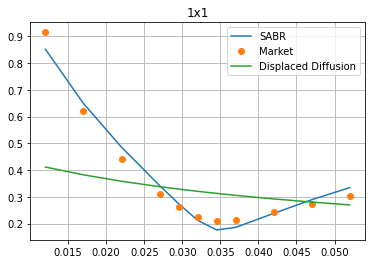

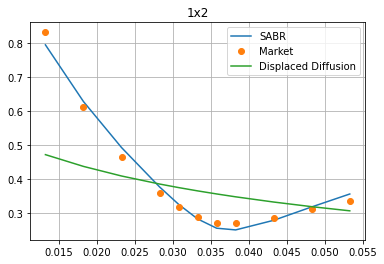

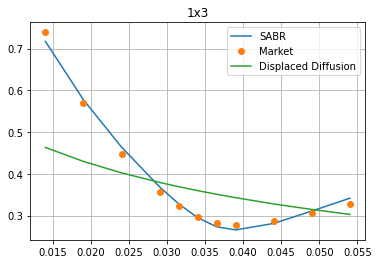

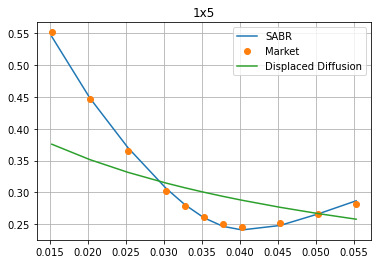

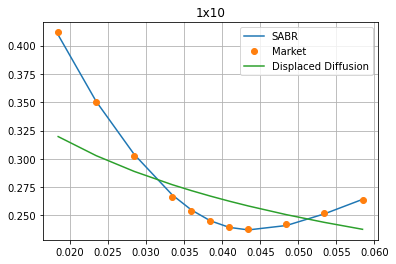

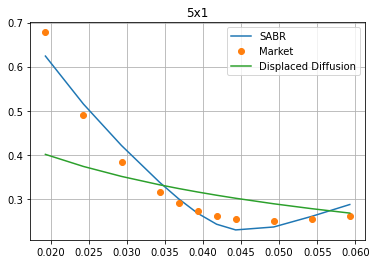

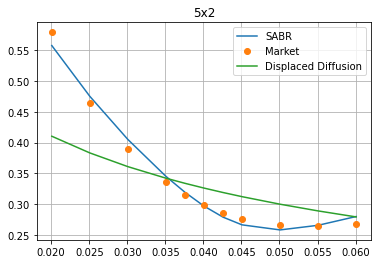

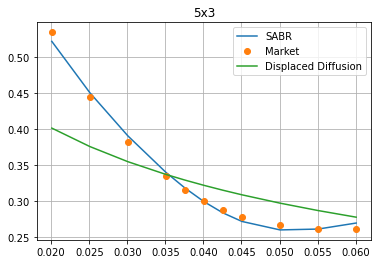

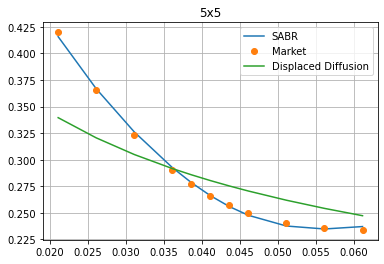

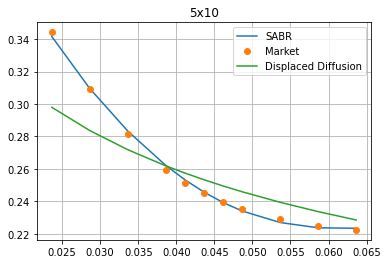

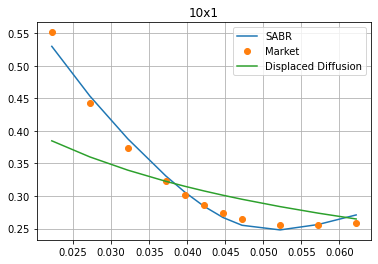

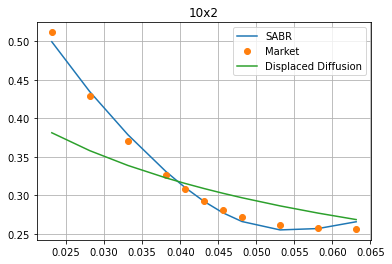

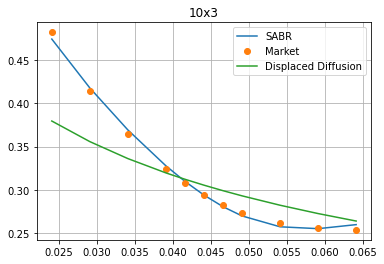

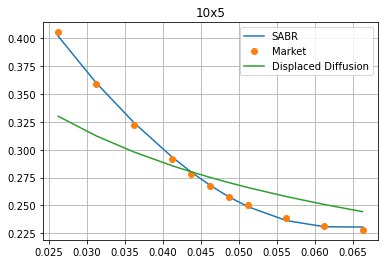

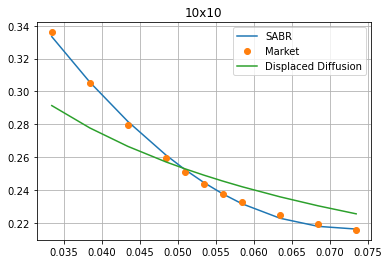

In [37]:
for row in df_SABRImpVol.index:
    for col in df_SABRImpVol.columns[2:13]:
        df_SABRImpVol.loc[row, col] = SABR2(
                df_SABRImpVol.loc[row,'FSR'],
                df_Strikes.loc[row, col],
                T_2[row], 
                df_SABRImpVol.loc[row, 'α'], 
                SABRbeta,
                df_SABRImpVol.loc[row, 'ρ'],
                df_SABRImpVol.loc[row, 'ν'])
    plt.plot(df_Strikes.iloc[row, 2:],df_SABRImpVol.iloc[row, 2:13],label='SABR')
    plt.plot(df_Strikes.iloc[row, 2:],df_SABR.iloc[row, 0:13],'o',label='Market')
    plt.plot(df_Strikes.iloc[row, 2:],df_DDImpVol.iloc[:,row],label="Displaced Diffusion")
    plt.legend()
    plt.grid()
    plt.title(ExpTenor[row])
    plt.show()